In [1]:
import numpy as np
import argparse



def stat_sim(N, distr, level=0.95, verbose=False):
    """
    This function generates N data and calculate the mean, the standard deviation and the
    confidence interval of the mean.
    """
    # Generate N iid RVs
    if distr == "unif":
        data = np.random.uniform(0, 1, N)
    elif distr == "norm":
        data = np.random.normal(0, 1, N)
    
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std = np.std(data)

    from scipy.stats import norm
    # Calculate confidence interval
    eta = norm.ppf((1-level)/2)
    mean_plus = mean+std/np.sqrt(N)*eta
    mean_minus = mean-std/np.sqrt(N)*eta

    if verbose: 
        print("The mean is {:.2f} and the standard deviation is {:.2f}.".format(mean, std))
        print("The CI of the mean for eta = {:.2f} is [{:.2f}, {:.2f}].".format(eta, mean_plus, mean_minus))

    return mean, std, mean_plus, mean_minus

 

#     Using MATLAB’s random number generator, run the following experiment
# a. Generate n iid U(0,1) r.v.’s, and compute sample mean and sample variance
# b. Study the accuracy of the estimate with respect to the true value vs. n
# c. Find confidence intervals for the variance vs. n
# d. Find 95% prediction interval using theory and using bootstrap

In [3]:
# simulation with 48 iid unif(0,1)
unif_mean, unif_std, unif_mean_plus, unif_mean_minus = stat_sim(N=48, distr="unif")
print('simulation with 48 iid unif(0,1)')
print('mean: {:.2f}'.format(unif_mean))
print('std: {:.2f}'.format(unif_std))
print('CI: [{:.2f}, {:.2f}]'.format(unif_mean_minus, unif_mean_plus))

# Repeat the experiment independently for 1000 times
n_it = 1000
import pandas as pd
unif_df = pd.DataFrame(np.zeros(shape=(n_it,4)), columns=["mean", "std", "mean_low", "mean_up"] )
for i in range(n_it): unif_df.iloc[i,:] = stat_sim(N=48, distr="unif")

# find how many times the confidence interval does not contain the TRUE VALUE of the mean;
n_errors = 0
for low, up in zip(unif_df["mean_low"], unif_df["mean_up"]):
    if 0.5 < low or 0.5 > up: n_errors += 1
print("Observed probability of error {:.2f}.".format(n_errors/n_it))

simulation with 48 iid unif(0,1)
mean: 0.55
std: 0.27
CI: [0.63, 0.47]
Observed probability of error 0.07.


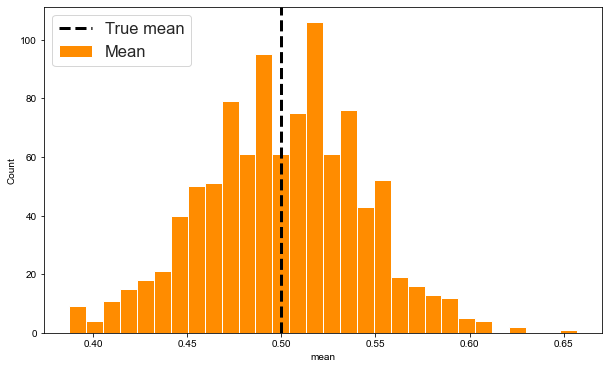

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(figsize=(10,6))
sns.set_theme(style='white',palette='Dark2',font_scale=1.5)
sns.histplot(x='mean', data=unif_df, color='darkorange', bins=30, alpha=1, label='Mean')
ax.axvline(x=0.5, color='black', linestyle='--', label='True mean', linewidth=3)
ax.legend(loc='upper left')
fig.savefig('figs/mean_distr.png', bbox_inches='tight')

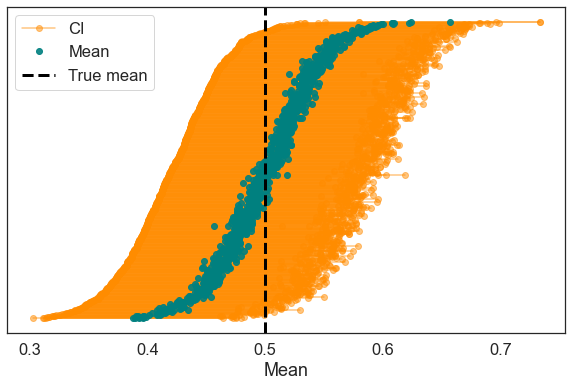

In [5]:
#plot the results ordering the intervals by increasing lower extreme of the CI
unif_df.sort_values(by='mean_low', inplace=True)
fig,ax=plt.subplots( figsize=(10,6))
for lower, upper, y in zip(unif_df['mean_low'],unif_df['mean_up'], range(len(unif_df))):
    ax.plot((lower,upper), (y,y),'ro-',color='darkorange', alpha=0.5)
ax.plot((lower,upper), (y,y),'ro-',color='darkorange', alpha=0.5, label='CI')
ax.plot(unif_df['mean'], range(len(unif_df)),'ro',color='teal', alpha=0.9, label = 'Mean')
ax.axvline(x=0.5, color='black', linestyle='--', label='True mean', linewidth=3)
ax.legend(loc='upper left')
ax.set_yticklabels('')
ax.set_xlabel('Mean')
fig.savefig('figs/unif_mean_CI.png', bbox_inches='tight')

In [31]:
# Generate n iid U(0,1) r.v.’s, and compute sample mean and sample variance
nmax = 20
ns = [2**i for i in range(1,nmax)]
N_df = pd.DataFrame(np.zeros(shape=(len(ns),5)), columns=["N", "mean", "std", "mean_low", "mean_up"] )
for i in range(len(ns)):
    N_df.iloc[i,:] =np.concatenate([[ns[i]], stat_sim(N=ns[i], distr="unif")])

# Study the accuracy of the estimate with respect to the true value vs. n
N_df['mean_accuracy'] = np.log10(1/abs(N_df['mean']-0.5))

# Find confidence intervals for the variance vs. n
level = 0.95
from scipy.stats import chi2
N_df['std_low'] = N_df['mean'] - N_df['std']*np.sqrt((chi2.ppf((1-level)/2, df=N_df['N']-1)/(N_df['N']-1)))
N_df['std_up'] = N_df['mean'] + N_df['std']*np.sqrt((chi2.ppf((1+level)/2, df=N_df['N']-1)/(N_df['N']-1)))

No handles with labels found to put in legend.


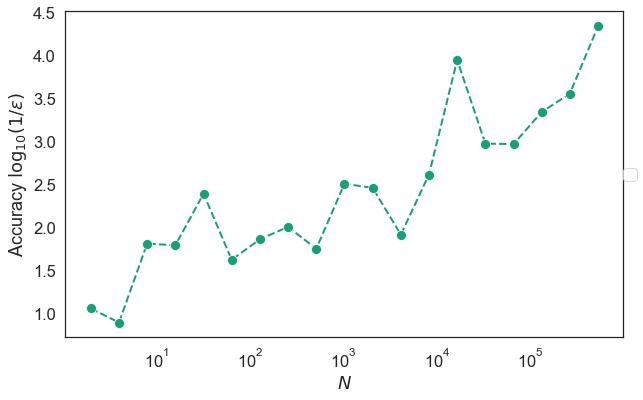

In [42]:
fig,ax=plt.subplots(figsize=(10,6))
sns.set_theme(style='white',palette='Dark2',font_scale=1.5)
lw=2
ms=10
ls='--'
g=sns.lineplot(x='N', y='mean_accuracy', ax=ax, data=N_df, marker='o', 
                markersize=ms,linewidth=lw, linestyle=ls)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.)
ax.set_ylabel(r"Accuracy $\log_{10}(1/\epsilon)$")
ax.set_xlabel(r"$N$")
ax.set_xscale('log')
fig.savefig('figs/unif_mean_accuracy.pdf', bbox_inches='tight')

Text(0.5, 0, 'STD')

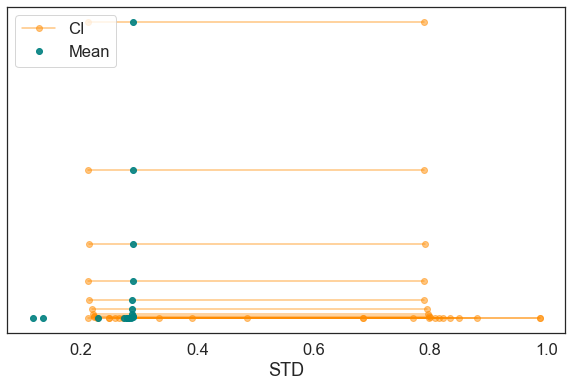

In [30]:
#plot confidence intervals for the variance vs. n
N_df.sort_values(by='std_low', inplace=True)
fig,ax=plt.subplots( figsize=(10,6))
for lower, upper, y in zip(N_df['std_low'],N_df['std_up'], N_df['N']):
    ax.plot((lower,upper), (y,y),'ro-',color='darkorange', alpha=0.5)

ax.plot((lower,upper), (y,y),'ro-',color='darkorange', alpha=0.5, label='CI')
ax.plot(N_df['std'], N_df['N'],'ro',color='teal', alpha=0.9, label = 'Mean')
ax.legend(loc='upper left')
ax.set_yticklabels('')
ax.set_xlabel('STD')
